<a href="https://colab.research.google.com/github/Feldt/DeepLearning_NoteBook/blob/main/CIFAR10_Autoencoder_CNN_BaselineReto_SinSolucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

Cargar el dataset cifar10 en un conjunto inicial de training (imagenes y labels) y test (imágenes y labels)

In [26]:
(x_train0, y_train0), (x_test0, y_test0) = datasets.cifar10.load_data()

print(f"Forma del conjunto de entrenamiento: {x_train0.shape}")
print(f"Forma del conjunto de prueba: {x_test0.shape}")
print(f"Rango de valores originales: {x_train0.min()} - {x_train0.max()}")


Forma del conjunto de entrenamiento: (50000, 32, 32, 3)
Forma del conjunto de prueba: (10000, 32, 32, 3)
Rango de valores originales: 0 - 255


In [27]:
# lista de etiquetas CIFAR10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

### 1. Pre-procesamiento del dataset

a. Convierte los pixeles de las imágenes del conjunto de train y test a tipo float

b. Normaliza, dividiendo el valor de todos los pixeles por 255, ya que es el valor máximo de intensidad de cada pixel.

c. Codifica las etiquetas y_train y y_test como one-hot utilizando la funcion to_categorical


In [28]:
# Convierte los pixeles de las imágenes del conjunto de train y test a tipo float
x_train = x_train0.astype('float32')
x_test = x_test0.astype('float32')

print(f"Despues de conversion a float32:")
print(f"x_train dtype: {x_train.dtype}")
print(f"x_test dtype: {x_test.dtype}")

# dividiendo el valor de todos los pixeles por 255, ya que es el valor máximo de intensidad de cada pixel.
x_train  = x_train / 255
x_test = x_test / 255

print(f"Despues de normalizacion:")
print(f"Rango x_train: {x_train.min()} - {x_train.max()}")
print(f"Rango x_test: {x_test.min()} - {x_test.max()}")


# Codificar las etiquetas y_train y y_test como one-hot utilizando la funcion to_categorical
y_train = keras.utils.to_categorical(y_train0, 10)
y_test = keras.utils.to_categorical(y_test0,10)

print(f"Forma de etiquetas one-hot:")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Despues de conversion a float32:
x_train dtype: float32
x_test dtype: float32
Despues de normalizacion:
Rango x_train: 0.0 - 1.0
Rango x_test: 0.0 - 1.0
Forma de etiquetas one-hot:
y_train: (50000, 10)
y_test: (10000, 10)


Dividimos el test set en 7000 imagenes de validacion (x_val_images) y 3000 de test set (x_test_images)


In [29]:
# Renombrar por claridad
x_train_images = x_train
x_test_images = x_test


In [30]:
# Dividir test en validacion y test, 7000 de validacion y 3000 de test
x_val_images = x_test_images[:7000]
x_test_images = x_test_images[7000:]

print(f"Division de conjuntos:")
print(f"Training: {x_train_images.shape}")
print(f"Validation: {x_val_images.shape}")
print(f"Test: {x_test_images.shape}")


Division de conjuntos:
Training: (50000, 32, 32, 3)
Validation: (7000, 32, 32, 3)
Test: (3000, 32, 32, 3)


Dividimos las etiquetas de validacion (y_val y y_test) de tal forma que correspondan a los conjuntos previos.

In [31]:
# Dividir etiquetas de validacion
y_val_labels = y_test[:7000]
y_test_labels = y_test[7000:]

print(f"Division de etiquetas:")
print(f"Training labels: {y_train.shape}")
print(f"Validation labels: {y_val_labels.shape}")
print(f"Test labels: {y_test_labels.shape}")


Division de etiquetas:
Training labels: (50000, 10)
Validation labels: (7000, 10)
Test labels: (3000, 10)


In [32]:
# Algunos imports complementarios
from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D, MaxPool2D, Flatten, BatchNormalization
import keras.backend as K
from keras.models import Model

In [33]:

# Modelo encoder-decoder de referencia

print("=== CONSTRUYENDO MODELO ===")


input_img = Input(shape=(32, 32, 3))

# Red encoder
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

print(f"Forma del encoded: {encoded.shape}")


# Red decoder
x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

=== CONSTRUYENDO MODELO ===
Forma del encoded: (None, 4, 4, 16)


In [34]:
# Modelo Encoder-Decoder
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 4, 4, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 4, 4, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 52,975 (206.93 KB)

 Trainable params: 52,521 (205.16 KB)

 Non-trainable params: 454 (1.77 KB)

### 2. Entrenamiento de autoencoder

a. Entrena el modelo no-supervisado encoder-decoder de tal forma que el modelo aprenda a reconstruir su propio input, con batch_size 64, mínimo 20 épocas.

b. Investiga e implementa el uso de los callbacks de EarlyStopping y ModelCheckpoint

In [35]:

from keras.callbacks import EarlyStopping, ModelCheckpoint
print("=== ENTRENANDO MODELO BASELINE ===")

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_autoencoder.h5', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(x_train_images, x_train_images,
                    epochs=20,
                    batch_size=64,
                    shuffle=True,
                    validation_data=(x_val_images, x_val_images),
                    callbacks=[early_stop, checkpoint])

print(f"Training final loss: {history.history['loss'][-1]:.4f}")
print(f"Validation final loss: {history.history['val_loss'][-1]:.4f}")



=== ENTRENANDO MODELO BASELINE ===
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5981

782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.5981 - val_loss: 0.5795
Epoch 2/20
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5749

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.5748 - val_loss: 0.5740
Epoch 3/20
777/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5714

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.5714 - val_loss: 0.5702
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.5701 - val_loss: 0.5720
Epoch 5/20
775/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5678

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.5678 - val_loss: 0.5676
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5669

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.5669 - val_loss: 0.5670
Epoch 7/20
779/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5658

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.5658 - val_loss: 0.5666
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5657

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.5657 - val_loss: 0.5658
Epoch 9/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.5651 - val_loss: 0.5658
Epoch 10/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5650

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.5650 - val_loss: 0.5656
Epoch 11/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.5650 - val_loss: 0.5665
Epoch 12/20
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5648

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.5648 - val_loss: 0.5652
Epoch 13/20
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5640

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.5640 - val_loss: 0.5646
Epoch 14/20
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5638

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.5638 - val_loss: 0.5645
Epoch 15/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.5638 - val_loss: 0.5649
Epoch 16/20
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5637

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.5637 - val_loss: 0.5643
Epoch 17/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.5635 - val_loss: 0.5647
Epoch 18/20
777/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5628

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.5628 - val_loss: 0.5639
Epoch 19/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.5630 - val_loss: 0.5646
Epoch 20/20
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5631

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.5631 - val_loss: 0.5638
Training final loss: 0.5631
Validation final loss: 0.5638


c. Visualización del proceso de entrenamiento. Grafica Training Loss vs. Validation Loss.


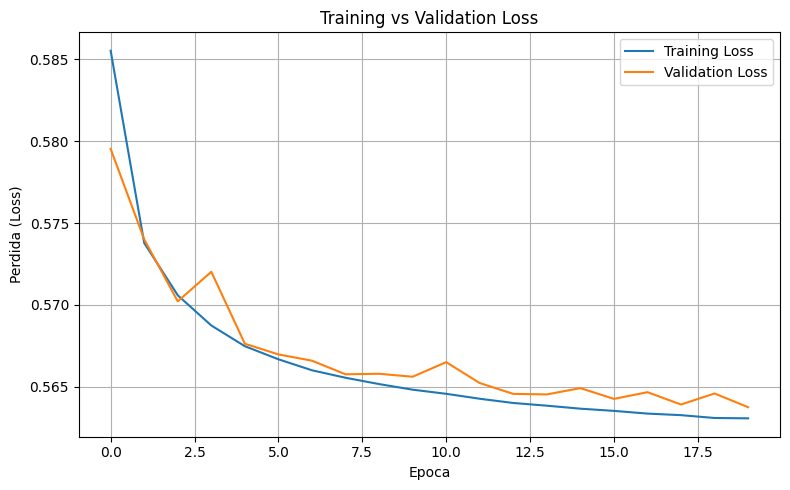

In [36]:
# Gráfica de Training Loss vs Validation Loss

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Perdida (Loss)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

d. Visualización del input reconstruido

Imprime un conjunto de imágenes originales y comparalas con la imagen reconstruida por el autoencoder.

Utiliza las siguientes funciones de referencia.

In [37]:
c10test = model.predict(x_test_images)
c10val = model.predict(x_val_images)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [38]:
# Funcion para mostrar imagenes originales y reconstruidas

def showOrigDec(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # reconstruidas
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


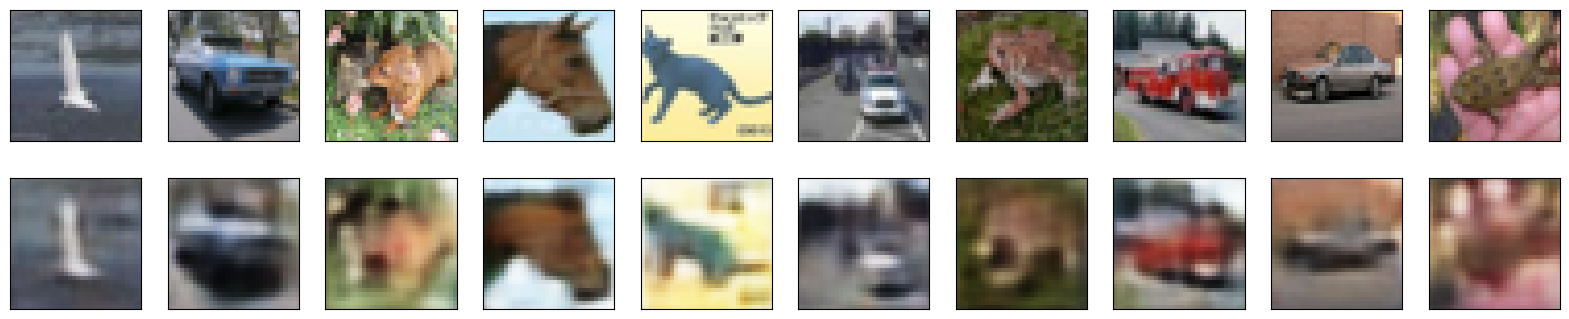

In [39]:
# Muestra algunas imagenes originales y reconstruidas utilizando tu funcion
showOrigDec(x_test_images, c10test)


A continuación generaremos el modelo encoder del autoencoder. Este modelo lo utilizarás para obtener la representación codificada de los conjuntos originales y con ella entrenar un clasificador.

In [40]:
# Modelo Encoder
encoder = Model(input_img, encoded)
encoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 16)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,328 (98.94 KB)

 Trainable params: 25,104 (98.06 KB)

 Non-trainable params: 224 (896.00 B)

### 3. Extracción de features del autoencoder

Utilizando el **método predict del modelo encoder** extrae las variables que te indicamos a continuación:

a. Codifica el el conjunto de imágenes de entrenamiento utilizando el método predict del encoder, y guárdalo en una variable llamada **gist_train_ae**

b. Codifica el conjunto de imágenes de validación, utilizando el método predict del encoder y guárdalo en una variable llamada **gist_valid_ae**

c. Codifica el conjunto de imágenes de prueba utilizando el método predict del encoder y guárdalo en una variable llamada **gist_test_ae**


In [41]:
# Completa esta función...
print("=== EXTRAYENDO FEATURES ")
gist_train_ae = encoder.predict(x_train_images)
gist_valid_ae = encoder.predict(x_val_images)
gist_test_ae = encoder.predict(x_test_images)


print(f"Forma de features extraídas (baseline):")
print(f"gist_train_ae: {gist_train_ae.shape}")
print(f"gist_valid_ae: {gist_valid_ae.shape}")
print(f"gist_test_ae: {gist_test_ae.shape}")

print(f"Rango de valores en features:")
print(f"Train features: {gist_train_ae.min():.4f} - {gist_train_ae.max():.4f}")


=== EXTRAYENDO FEATURES 
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Forma de features extraídas (baseline):
gist_train_ae: (50000, 4, 4, 16)
gist_valid_ae: (7000, 4, 4, 16)
gist_test_ae: (3000, 4, 4, 16)
Rango de valores en features:
Train features: 0.0000 - 5.4077


A continuación definimos un clasificador con una capa convolucional y dos capas densas, que aprenderá a clasificar el input una vez procesado por el codificador.

Puedes utilizar el siguiente clasificador como referencia:

In [42]:
num_classes = 10
input = Input((gist_train_ae.shape[1], gist_train_ae.shape[2], gist_train_ae.shape[3]))

x = Conv2D(64, 3, padding="same")(input)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(2)(x)
x = Dropout(0.5)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(num_classes, activation='softmax')(x)

decoder_classifier = Model(input, output)
decoder_classifier.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['acc'])
decoder_classifier.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 4, 4, 64)       │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,234 (172.79 KB)

 Trainable params: 43,850 (171.29 KB)

 Non-trainable params: 384 (1.50 KB)

### 4. Entrenamiento y evaluación del clasificador

a. Entrena el clasificador **decoder_classifier** definido en la fase previa utilizando como input la representación codificada del training set obtenida en el paso previo y como output los labels originales del conjunto de training.

b. Calcula la pérdida de validación del modelo, utilizando la representación codificada de los datos de validación y como ouput los labels originales del conjunto de validación.


In [43]:

print("=== ENTRENANDO CLASIFICADOR ===")
early_stop_clf = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_clf = ModelCheckpoint('best_decoder_classifier.h5', save_best_only=True, monitor='val_loss', mode='min')

callbacks = [early_stop_clf, checkpoint_clf]

history_clf = decoder_classifier.fit(gist_train_ae, y_train,
                       validation_data=(gist_valid_ae, y_val_labels),
                       batch_size=64, epochs=20, callbacks=callbacks)

print(f"Classifier - Final training accuracy: {history_clf.history['acc'][-1]:.4f}")
print(f"Classifier - Final validation accuracy: {history_clf.history['val_acc'][-1]:.4f}")


=== ENTRENANDO CLASIFICADOR ===
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.2284 - loss: 2.4284

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - acc: 0.2284 - loss: 2.4280 - val_acc: 0.3899 - val_loss: 1.6735
Epoch 2/20
773/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.3595 - loss: 1.7526

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - acc: 0.3596 - loss: 1.7524 - val_acc: 0.4199 - val_loss: 1.5960
Epoch 3/20
772/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.3835 - loss: 1.6858

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.3836 - loss: 1.6856 - val_acc: 0.4344 - val_loss: 1.5458
Epoch 4/20
769/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.3996 - loss: 1.6585

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.3997 - loss: 1.6583 - val_acc: 0.4343 - val_loss: 1.5420
Epoch 5/20
763/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.4123 - loss: 1.6189

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.4122 - loss: 1.6190 - val_acc: 0.4853 - val_loss: 1.4774
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.4224 - loss: 1.6053 - val_acc: 0.4739 - val_loss: 1.4803
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.4276 - loss: 1.5906 - val_acc: 0.4353 - val_loss: 1.5722
Epoch 8/20
772/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.4311 - loss: 1.5741

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.4312 - loss: 1.5741 - val_acc: 0.4660 - val_loss: 1.4763
Epoch 9/20
777/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.4395 - loss: 1.5487

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.4395 - loss: 1.5487 - val_acc: 0.4687 - val_loss: 1.4594
Epoch 10/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.4431 - loss: 1.5455 - val_acc: 0.4594 - val_loss: 1.4848
Epoch 11/20
769/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.4487 - loss: 1.5255

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.4487 - loss: 1.5255 - val_acc: 0.4767 - val_loss: 1.4328
Epoch 12/20
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.4531 - loss: 1.5233

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.4531 - loss: 1.5233 - val_acc: 0.5043 - val_loss: 1.3950
Epoch 13/20
767/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.4517 - loss: 1.5153

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.4518 - loss: 1.5153 - val_acc: 0.4983 - val_loss: 1.3753
Epoch 14/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.4589 - loss: 1.5005 - val_acc: 0.5063 - val_loss: 1.3759
Epoch 15/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.4551 - loss: 1.5040 - val_acc: 0.4811 - val_loss: 1.4321
Epoch 16/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.4623 - loss: 1.4960 - val_acc: 0.4841 - val_loss: 1.4508
Epoch 17/20
774/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.4609 - loss: 1.4900

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.4609 - loss: 1.4900 - val_acc: 0.5160 - val_loss: 1.3602
Epoch 18/20
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.4660 - loss: 1.4869

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.4660 - loss: 1.4869 - val_acc: 0.5207 - val_loss: 1.3510
Epoch 19/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.4705 - loss: 1.4766 - val_acc: 0.5021 - val_loss: 1.3777
Epoch 20/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.4685 - loss: 1.4749 - val_acc: 0.5031 - val_loss: 1.3846
Classifier - Final training accuracy: 0.4714
Classifier - Final validation accuracy: 0.5031


c. Genera predicciones con el modelo clasificador, utiliza el conjunto de test codificado modelo encoder. Guárdalo en la variable pred.




In [44]:
# Obtener las etiquetas con el clasificador
pred = decoder_classifier.predict(gist_test_ae)

# Convertimos las predicciones a una lista de etiquetas única
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)

print("=== RESULTADOS  ===")
print(f"Forma de predicciones: {pred.shape}")
print(f"Primeras 10 predicciones (clases): {pred_classes[:10]}")
print(f"Primeras 10 etiquetas reales: {np.argmax(y_test_labels[:10], axis=1)}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[0 1 7 ... 5 4 7]
=== RESULTADOS  ===
Forma de predicciones: (3000, 10)
Primeras 10 predicciones (clases): [0 1 7 3 7 9 6 1 8 5]
Primeras 10 etiquetas reales: [2 1 3 7 3 1 6 9 1 6]


d. Evalúa las predicciones del modelo y obten la matriz de confusión.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

cm = confusion_matrix(np.argmax(y_test_labels, axis=1), pred_classes)
accuracy = accuracy_score(np.argmax(y_test_labels, axis=1), pred_classes)

print("Matriz de confusion:\n")
print(cm)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("Classification Report:\n")
cr=classification_report(y_test_labels.argmax(axis=1), pred.argmax(axis=1), target_names=class_names)
print(cr)


Matriz de confusion:

[[198   6  17   1   7   2   4   6  47   8]
 [ 20 189   3   4   6   4  11   3  34  37]
 [ 31   7  93  12  80  30  26  10   8   2]
 [ 18   7  23  90  30  67  37  15   7   8]
 [ 14   0  29  11 154  14  26  20   8   2]
 [  7   6  29  44  34 119  18  28   7   1]
 [  6   6  18  17  45   9 183   5   7   6]
 [ 11   3  11  11  50  26  16 158   3   9]
 [ 44  24   4   5   4   5   4   1 211  12]
 [ 27  75   1   7   7   3  13  13  28 133]]

Accuracy: 0.5093 (50.93%)
Classification Report:

              precision    recall  f1-score   support

    airplane       0.53      0.67      0.59       296
  automobile       0.59      0.61      0.60       311
        bird       0.41      0.31      0.35       299
         cat       0.45      0.30      0.36       302
        deer       0.37      0.55      0.44       278
         dog       0.43      0.41      0.42       293
        frog       0.54      0.61      0.57       302
       horse       0.61      0.53      0.57       298
        s

### 5. Mejoras a los modelos

Aplicando los conceptos del curso modifica dichas redes para obtener un mejor accuracy ¿Crees poder lograr un 70% o tal vez 80% de accuracy con tu modelo? OJO: NO está permitido modificar el modelo clasificador.

a.    Experimenta agregando capas, modificando operaciones y modificando las dimensiones de las capas actuales. OJO: Recuerda que para que tu modelo encoder-decoder siga funcionando y puedas reconstruir las imágenes codificadas, las capas de MaxPool del encoder deben de corresponder a las capas UpSample del decoder. Tip: ¿Las capas de pooling ayudan o perjudican a tu modelo?


b.    En una celda de texto, justifica los cambios realizados, a la arquitectura.


c.     Genera la matriz de confusión de tu ensamble de modelos mejorado. Recuerda que debes re-entrenar el clasificador si la arquitectura del autoencoder cambia.



#MEJORAS IMPLEMENTADAS

---

##1. AUTOENCODER:
   - Capas adicionales en cada bloque (64-64, 128-128, 256-256)
   - Skip connections para preservar información
   - Bottleneck más informativo (8x8x128)
   - Misma normalización que baseline  

## 2. CLASIFICADOR:
   - Más filtros iniciales (128 vs 64)
   - Capas adicionales en parte convolucional
   - Red densa más profunda (256->128->10)
   - Dropout moderado (0.25, 0.4)  

## 3. ENTRENAMIENTO:
   - Ligeramente más epochs (35 vs 30)
   - Mismos hiperparámetros base que funcionan
   - Early stopping conservador


In [46]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

Forma del encoded: (None, 8, 8, 128)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 32, 32,    │     36,928 │ activation_33[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 16,    │          0 │ activation_34[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 16, 16,    │    147,584 │ activation_35[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 8, 8, 128) │          0 │ activation_36[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 2,445,455 (9.33 MB)

 Trainable params: 2,441,865 (9.31 MB)

 Non-trainable params: 3,590 (14.02 KB)

=== ENTRENANDO MODELO ===
Epoch 1/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0039

782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 51ms/step - loss: 0.0039 - val_loss: 7.4630e-04
Epoch 2/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 43ms/step - loss: 6.4449e-04 - val_loss: 0.0016
Epoch 3/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.9845e-04

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 4.9846e-04 - val_loss: 7.3398e-04
Epoch 4/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - loss: 4.4897e-04 - val_loss: 0.0015
Epoch 5/35
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.3291e-04

782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - loss: 4.3291e-04 - val_loss: 3.2983e-04
Epoch 6/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 4.0033e-04 - val_loss: 6.8144e-04
Epoch 7/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - loss: 3.3518e-04 - val_loss: 3.8357e-04
Epoch 8/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - loss: 3.1238e-04 - val_loss: 4.5042e-04
Epoch 9/35
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.2030e-04

782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - loss: 3.2027e-04 - val_loss: 1.4032e-04
Epoch 10/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.6578e-04

782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - loss: 2.6579e-04 - val_loss: 1.0899e-04
Epoch 11/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 2.3602e-04 - val_loss: 1.3613e-04
Epoch 12/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - loss: 2.4375e-04 - val_loss: 1.7697e-04
Epoch 13/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - loss: 2.0935e-04 - val_loss: 1.2900e-04
Epoch 14/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 1.7393e-04 - val_loss: 1.9908e-04
Epoch 15/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - loss: 1.9988e-04 - val_loss: 1.5002e-04
Epoch 16/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - loss: 1.7890e-04 - val_loss: 1.1641e-04
Epoch 17/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 1.5457e-04 - val_loss: 6.0099e-04
Epoch 18/35
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.7046e-04

782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - loss: 1.7042e-04 - val_loss: 5.0875e-05
Epoch 19/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - loss: 1.4288e-04 - val_loss: 6.3711e-05
Epoch 20/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - loss: 1.3999e-04 - val_loss: 8.7361e-05
Epoch 21/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - loss: 1.3297e-04 - val_loss: 2.2225e-04
Epoch 22/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - loss: 1.3315e-04 - val_loss: 3.9305e-04
Epoch 23/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - loss: 1.2712e-04 - val_loss: 6.4851e-05
Epoch 24/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 1.0421e-04 - val_loss: 8.0311e-05
Epoch 25/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 1.1442e-04 - val_loss: 1.3182e-04
Epoch 26/35
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - loss: 1.0720e-04 - val_loss: 1.6006e-04
Improved Training final loss: 0.0001
Improved Validation final loss: 0.0002


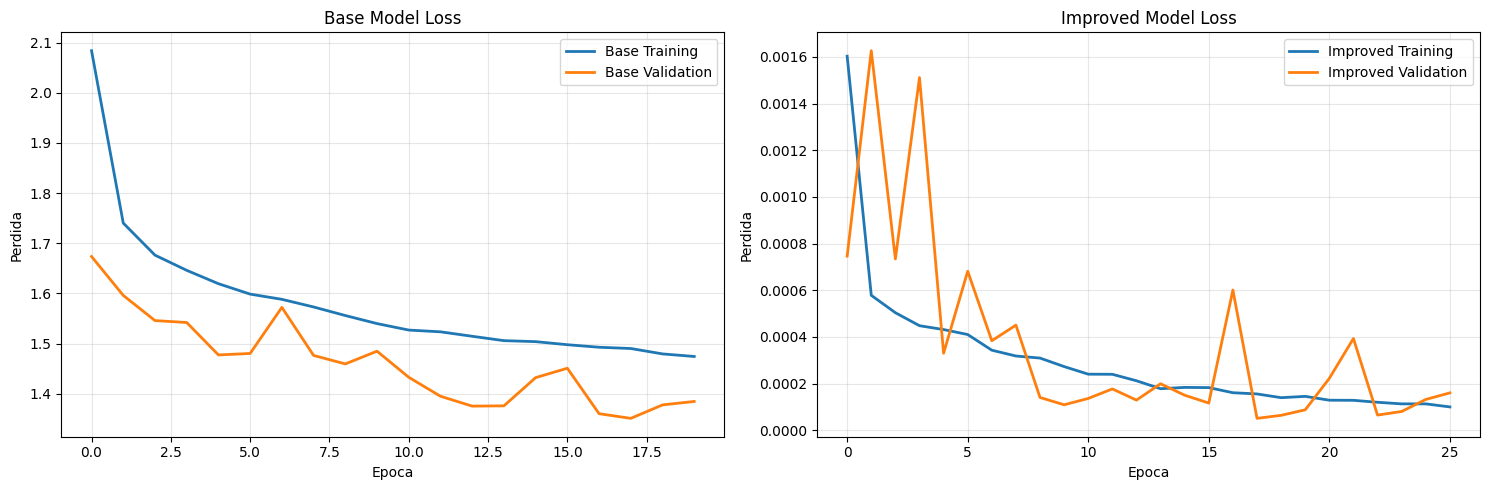

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
base: Original vs Reconstruida


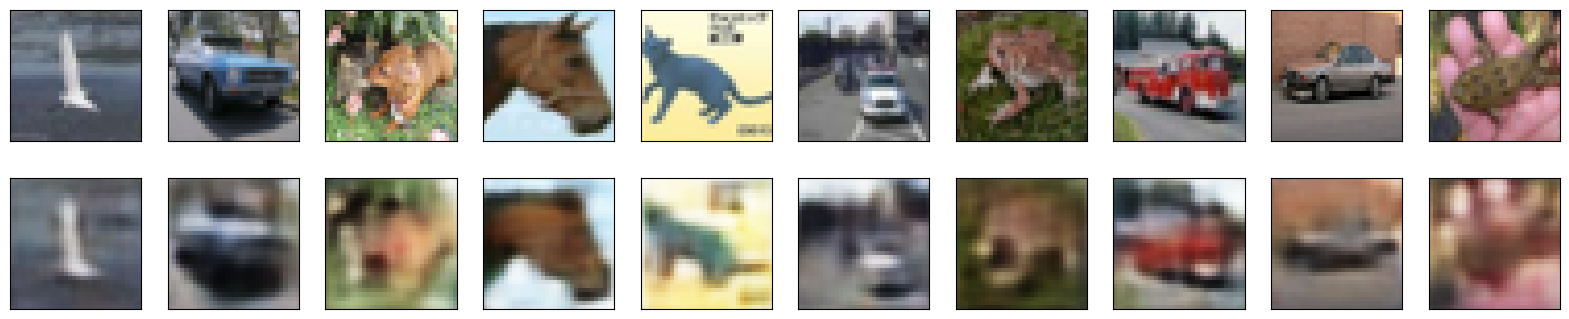

Improved: Original vs Reconstruida


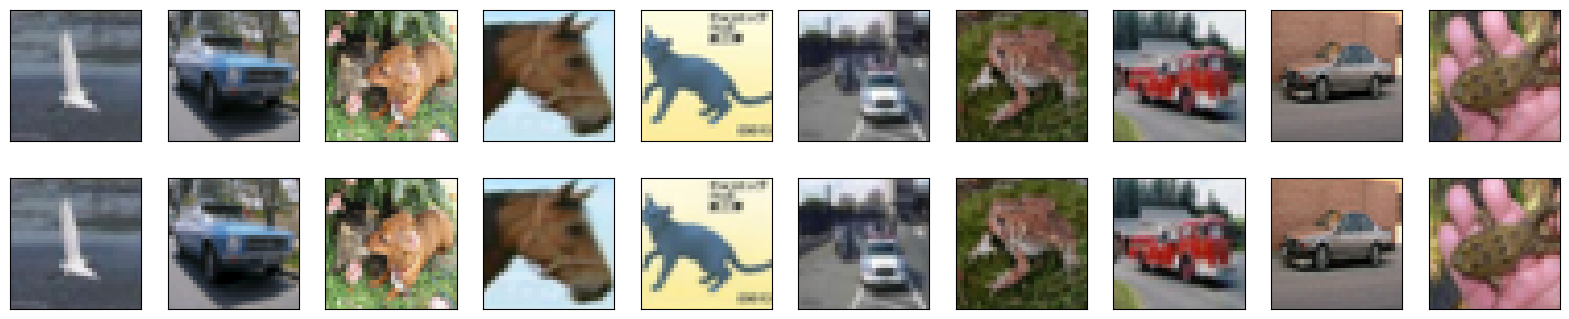

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 8, 8, 128)      │       295,04

 Total params: 1,444,544 (5.51 MB)

 Trainable params: 1,442,496 (5.50 MB)

 Non-trainable params: 2,048 (8.00 KB)

=== EXTRAYENDO FEATURES DEL MODELO MEJORADO ===
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Forma de features extraidas (mejorado):
gist_train_ae: (50000, 8, 8, 128)
gist_valid_ae: (7000, 8, 8, 128)
gist_test_ae: (3000, 8, 8, 128)
Rango de valores en features mejoradas:
Train features: 0.0000 - 20.6523
=== ENTRENANDO CLASIFICADOR MEJORADO ===
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.2033 - loss: 2.4574

782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - acc: 0.2033 - loss: 2.4571 - val_acc: 0.3534 - val_loss: 1.8011
Epoch 2/30
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.3381 - loss: 1.8299

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.3382 - loss: 1.8297 - val_acc: 0.3647 - val_loss: 1.7795
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.3932 - loss: 1.6796

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.3932 - loss: 1.6796 - val_acc: 0.4187 - val_loss: 1.6278
Epoch 4/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.4159 - loss: 1.6079

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.4159 - loss: 1.6079 - val_acc: 0.4140 - val_loss: 1.6136
Epoch 5/30
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.4410 - loss: 1.5573

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.4410 - loss: 1.5572 - val_acc: 0.4344 - val_loss: 1.6019
Epoch 6/30
775/782 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.4582 - loss: 1.5034

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.4582 - loss: 1.5034 - val_acc: 0.4801 - val_loss: 1.4745
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.4789 - loss: 1.4617 - val_acc: 0.4401 - val_loss: 1.5627
Epoch 8/30
777/782 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.4853 - loss: 1.4384

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - acc: 0.4853 - loss: 1.4384 - val_acc: 0.4796 - val_loss: 1.4454
Epoch 9/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.5052 - loss: 1.3930 - val_acc: 0.4779 - val_loss: 1.4855
Epoch 10/30
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.5162 - loss: 1.3649

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.5161 - loss: 1.3650 - val_acc: 0.4936 - val_loss: 1.4356
Epoch 11/30
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5274 - loss: 1.3255

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - acc: 0.5274 - loss: 1.3255 - val_acc: 0.4860 - val_loss: 1.4226
Epoch 12/30
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5445 - loss: 1.2916

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.5444 - loss: 1.2917 - val_acc: 0.5111 - val_loss: 1.3776
Epoch 13/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.5536 - loss: 1.2584 - val_acc: 0.4827 - val_loss: 1.5071
Epoch 14/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.5652 - loss: 1.2314 - val_acc: 0.5060 - val_loss: 1.4171
Epoch 15/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.5750 - loss: 1.2067 - val_acc: 0.5120 - val_loss: 1.4160
Epoch 16/30
778/782 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.5888 - loss: 1.1705

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.5888 - loss: 1.1707 - val_acc: 0.5214 - val_loss: 1.3686
Epoch 17/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.6009 - loss: 1.1312 - val_acc: 0.5216 - val_loss: 1.3769
Epoch 18/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.6062 - loss: 1.1170 - val_acc: 0.5166 - val_loss: 1.4060
Epoch 19/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.6106 - loss: 1.0996 - val_acc: 0.5076 - val_loss: 1.4488
Epoch 20/30
775/782 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.6227 - loss: 1.0737

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - acc: 0.6227 - loss: 1.0739 - val_acc: 0.5273 - val_loss: 1.3556
Epoch 21/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.6333 - loss: 1.0439 - val_acc: 0.5199 - val_loss: 1.4315
Epoch 22/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.6395 - loss: 1.0258 - val_acc: 0.5309 - val_loss: 1.3711
Epoch 23/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.6468 - loss: 1.0137 - val_acc: 0.5246 - val_loss: 1.3938
Epoch 24/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - acc: 0.6578 - loss: 0.9809 - val_acc: 0.5197 - val_loss: 1.4158
Epoch 25/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.6650 - loss: 0.9592 - val_acc: 0.5241 - val_loss: 1.3858
Epoch 26/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - acc: 0.6682 - loss: 0.9498 - val_acc: 0.5151 - val_loss: 1.4898
Epoch 27/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - acc: 0.6739 - loss: 0.9271 - val_acc: 0.5354 - val_loss: 1.3911
Improved Classifier - Final training accuracy: 0.6679
Imp

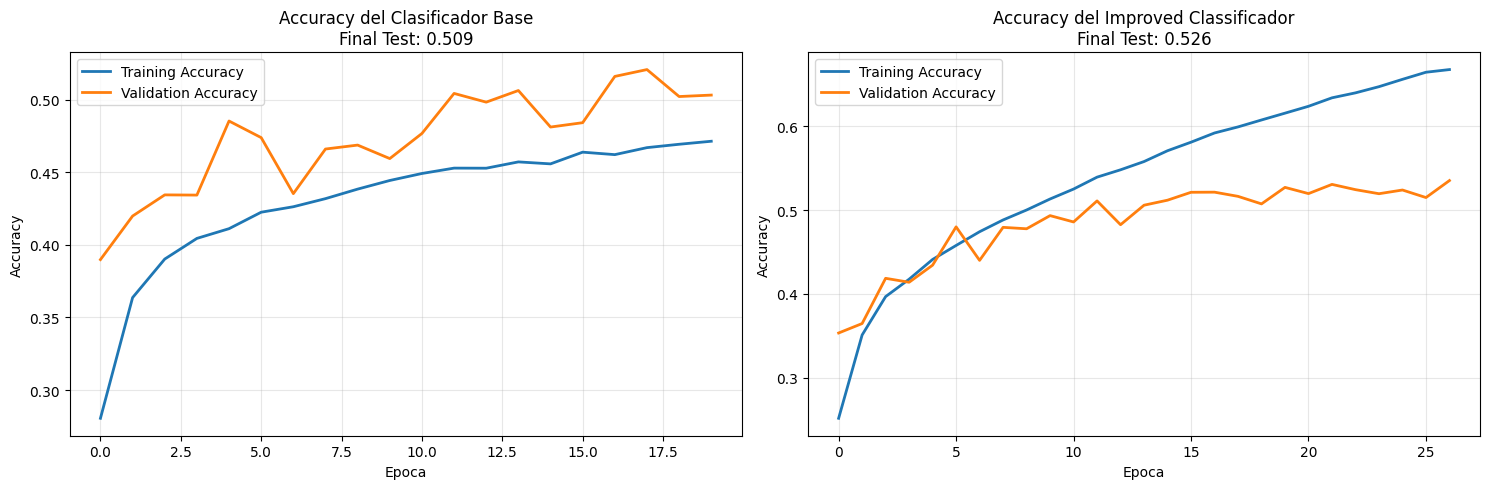

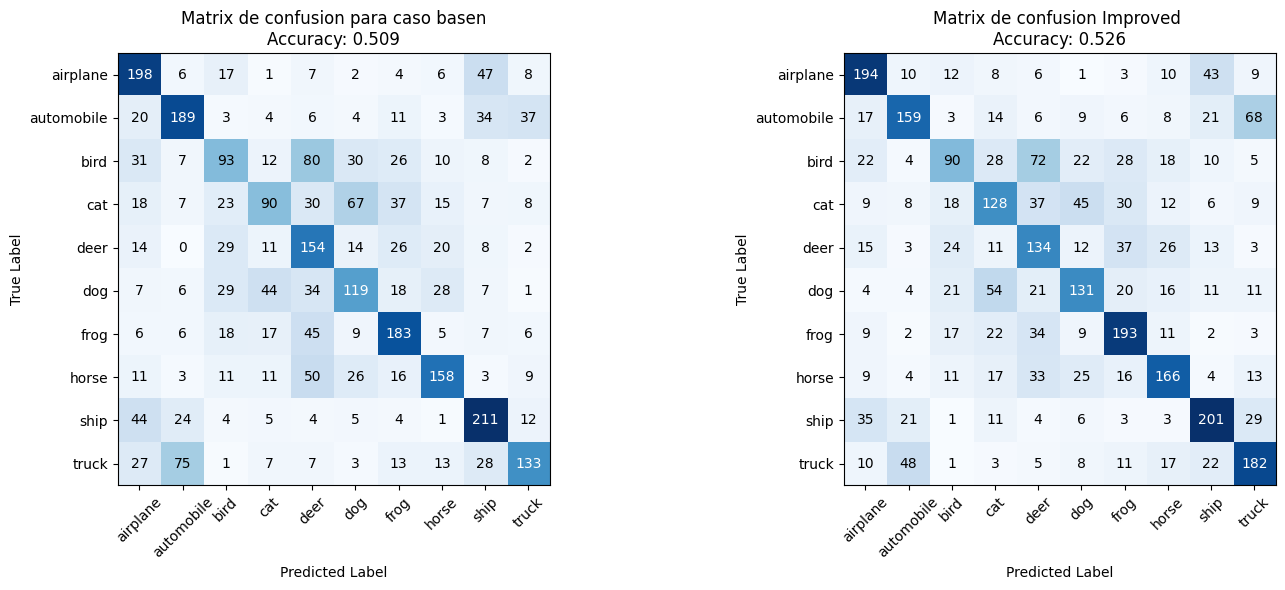


ANALISIS POR CLASE - MEJORAS ESPECIFICAS
Clase        Base F1      Improved F1  Mejora    
airplane     0.589        0.626           3.7%
automobile   0.596        0.554          -4.2%
bird         0.353        0.362           0.9%
cat          0.357        0.428           7.1%
deer         0.443        0.425          -1.8%
dog          0.416        0.467           5.1%
frog         0.572        0.595           2.3%
horse        0.567        0.568           0.0%
ship         0.626        0.621          -0.5%
truck        0.507        0.570           6.3%


In [47]:
# MODELO - ENFOQUE CONSERVADOR Y EFECTIVO
input_img_improved = Input(shape=(32, 32, 3))

# Encoder - cambios graduales para baseline
x = Conv2D(64, (3, 3), padding='same')(input_img_improved)  # Sin regularizacion excesiva
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)  # Capa adicional en primer bloque
x = BatchNormalization()(x)
x = Activation('relu')(x)
skip1 = x  # Skip connection
x = MaxPooling2D((2, 2), padding='same')(x)  # 16x16

x = Conv2D(128, (3, 3), padding='same')(x)  # Incremento gradual de filtros
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
skip2 = x  # Skip connection
x = MaxPooling2D((2, 2), padding='same')(x)  # 8x8

x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Bottleneck más informativo
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
encoded_improved = Activation('relu')(x)  # 8x8x128

print(f"Forma del encoded: {encoded_improved.shape}")

# Decoder - con skip connections
x = Conv2D(128, (3, 3), padding='same')(encoded_improved)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = UpSampling2D((2, 2))(x)  # 16x16
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Skip connection
x = Add()([x, skip2])
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = UpSampling2D((2, 2))(x)  # 32x32
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Skip connection
x = Add()([x, skip1])
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded_improved = Activation('sigmoid')(x)  # sigmoid para [0,1]

# Modelo
model_improved = Model(input_img_improved, decoded_improved)
model_improved.compile(optimizer='adam', loss='mse')  # Mantenemos adam simple
model_improved.summary()

print("=== ENTRENANDO MODELO ===")

# Callbacks conservadores
early_stop_improved = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint_improved = ModelCheckpoint('best_autoencoder_improved.h5', save_best_only=True, monitor='val_loss', mode='min')

# USAR LOS MISMOS DATOS QUE LA VERSION INICIAL - NO cambia normalizacion
x_train_normalized = x_train_images
x_val_normalized = x_val_images
x_test_normalized = x_test_images

history_improved = model_improved.fit(x_train_normalized, x_train_normalized,
                                    epochs=35,  # Solo un poco más que inicial
                                    batch_size=64,  # Mismo batch size que inicial
                                    shuffle=True,
                                    validation_data=(x_val_normalized, x_val_normalized),
                                    callbacks=[early_stop_improved, checkpoint_improved],
                                    verbose=1)

print(f"Improved Training final loss: {history_improved.history['loss'][-1]:.4f}")
print(f"Improved Validation final loss: {history_improved.history['val_loss'][-1]:.4f}")

# Comparacion de perdidas
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_clf.history['loss'], label='Base Training', linewidth=2)
plt.plot(history_clf.history['val_loss'], label='Base Validation', linewidth=2)
plt.title('Base Model Loss')
plt.xlabel('Epoca')
plt.ylabel('Perdida')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_improved.history['loss'], label='Improved Training', linewidth=2)
plt.plot(history_improved.history['val_loss'], label='Improved Validation', linewidth=2)
plt.title('Improved Model Loss')
plt.xlabel('Epoca')
plt.ylabel('Perdida')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Predicciones del modelo mejorado
c10test_improved = model_improved.predict(x_test_normalized)
c10val_improved = model_improved.predict(x_val_normalized)

# Comparacion visual de reconstrucciones
print("base: Original vs Reconstruida")
showOrigDec(x_test_images, c10test)
print("Improved: Original vs Reconstruida")
showOrigDec(x_test_images, c10test_improved)

# Encoder mejorado
encoder_improved = Model(input_img_improved, encoded_improved)
encoder_improved.summary()

print("=== EXTRAYENDO FEATURES DEL MODELO MEJORADO ===")

# Extraer features
gist_train_ae_improved = encoder_improved.predict(x_train_normalized)
gist_valid_ae_improved = encoder_improved.predict(x_val_normalized)
gist_test_ae_improved = encoder_improved.predict(x_test_normalized)

print(f"Forma de features extraidas (mejorado):")
print(f"gist_train_ae: {gist_train_ae_improved.shape}")
print(f"gist_valid_ae: {gist_valid_ae_improved.shape}")
print(f"gist_test_ae: {gist_test_ae_improved.shape}")

print(f"Rango de valores en features mejoradas:")
print(f"Train features: {gist_train_ae_improved.min():.4f} - {gist_train_ae_improved.max():.4f}")

# CLASIFICADOR MEJORADO
input_classifier_improved = Input(gist_train_ae_improved.shape[1:])

# Empezar con mas filtros para features mas ricas
x = Conv2D(128, 3, padding="same")(input_classifier_improved)  # Mas filtros que base
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, 3, padding="same")(x)  # Capa adicional
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(2)(x)
x = Dropout(0.25)(x)  # Menos dropout

x = Conv2D(256, 3, padding="same")(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(2)(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)  # Mas neuronas que en base
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)  # Capa adicional
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(num_classes, activation='softmax')(x)

decoder_classifier_improved = Model(input_classifier_improved, output)
decoder_classifier_improved.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['acc'])

print("=== ENTRENANDO CLASIFICADOR MEJORADO ===")

early_stop_clf_improved = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint_clf_improved = ModelCheckpoint('best_decoder_classifier_improved.h5', save_best_only=True, monitor='val_loss', mode='min')

callbacks_improved = [early_stop_clf_improved, checkpoint_clf_improved]

history_clf_improved = decoder_classifier_improved.fit(gist_train_ae_improved, y_train,
                                                     validation_data=(gist_valid_ae_improved, y_val_labels),
                                                     batch_size=64, epochs=30, callbacks=callbacks_improved,
                                                     verbose=1)

print(f"Improved Classifier - Final training accuracy: {history_clf_improved.history['acc'][-1]:.4f}")
print(f"Improved Classifier - Final validation accuracy: {history_clf_improved.history['val_acc'][-1]:.4f}")

# Predicciones del clasificador mejorado
pred_improved = decoder_classifier_improved.predict(gist_test_ae_improved)
pred_classes_improved = np.argmax(pred_improved, axis=1)

print("=== RESULTADOS MODELO MEJORADO ===")
print(f"Forma de predicciones: {pred_improved.shape}")
print(f"Primeras 10 predicciones: {pred_classes_improved[:10]}")

# Evaluacion del modelo mejorado
cm_improved = confusion_matrix(np.argmax(y_test_labels, axis=1), pred_classes_improved)
accuracy_improved = accuracy_score(np.argmax(y_test_labels, axis=1), pred_classes_improved)

print("=== MATRIZ DE CONFUSIÓN MODELO MEJORADO ===")
print(cm_improved)
print(f"\nAccuracy Mejorado: {accuracy_improved:.4f} ({accuracy_improved*100:.2f}%)")
print("\n=== CLASSIFICATION REPORT MODELO MEJORADO ===")
cr_improved = classification_report(y_test_labels.argmax(axis=1), pred_improved.argmax(axis=1), target_names=class_names)
print(cr_improved)

# Comparación final de resultados
print("="*60)
print("COMPARACIoN FINAL DE RESULTADOS")
print("="*60)
print(f"MODELO BASE:")
print(f"  - Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - Final training loss: {history.history['loss'][-1]:.4f}")
print(f"  - Final validation loss: {history.history['val_loss'][-1]:.4f}")
print(f"  - Classifier val accuracy: {history_clf.history['val_acc'][-1]:.4f}")

print(f"\nIMPROVED MODEL:")
print(f"  - Accuracy: {accuracy_improved:.4f} ({accuracy_improved*100:.2f}%)")
print(f"  - Final training loss: {history_improved.history['loss'][-1]:.4f}")
print(f"  - Final validation loss: {history_improved.history['val_loss'][-1]:.4f}")
print(f"  - Classifier val accuracy: {history_clf_improved.history['val_acc'][-1]:.4f}")

mejora_absoluta = (accuracy_improved - accuracy) * 100
mejora_relativa = ((accuracy_improved - accuracy) / accuracy) * 100

print(f"\nMEJORA ABSOLUTA: {mejora_absoluta:.2f} puntos porcentuales")
print(f"MEJORA RELATIVA: {mejora_relativa:.2f}%")

# Visualización de accuracies del clasificador
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_clf.history['acc'], label='Training Accuracy', linewidth=2)
plt.plot(history_clf.history['val_acc'], label='Validation Accuracy', linewidth=2)
plt.title(f'Accuracy del Clasificador Base\nFinal Test: {accuracy:.3f}')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_clf_improved.history['acc'], label='Training Accuracy', linewidth=2)
plt.plot(history_clf_improved.history['val_acc'], label='Validation Accuracy', linewidth=2)
plt.title(f'Accuracy del Improved Classificador\nFinal Test: {accuracy_improved:.3f}')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Matriz de confusion visual
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# matrix de confusion para caso base
im1 = ax1.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title(f'Matrix de confusion para caso basen\nAccuracy: {accuracy:.3f}')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.set_xticks(range(10))
ax1.set_yticks(range(10))
ax1.set_xticklabels(class_names, rotation=45)
ax1.set_yticklabels(class_names)

for i in range(10):
    for j in range(10):
        text = ax1.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")

# # matrix de confusion improved
im2 = ax2.imshow(cm_improved, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title(f'Matrix de confusion Improved \nAccuracy: {accuracy_improved:.3f}')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.set_xticks(range(10))
ax2.set_yticks(range(10))
ax2.set_xticklabels(class_names, rotation=45)
ax2.set_yticklabels(class_names)

# improved
for i in range(10):
    for j in range(10):
        text = ax2.text(j, i, cm_improved[i, j], ha="center", va="center", color="white" if cm_improved[i, j] > cm_improved.max()/2 else "black")

plt.tight_layout()
plt.show()


# Analisis de cuales clases mejoraron mas
print("\n" + "="*60)
print("ANALISIS POR CLASE - MEJORAS ESPECIFICAS")
print("="*60)

from sklearn.metrics import precision_recall_fscore_support

# Metricas por clase
precision_base, recall_base, f1_base, support_base = precision_recall_fscore_support(
    np.argmax(y_test_labels, axis=1), pred_classes, average=None)

precision_imp, recall_imp, f1_imp, support_imp = precision_recall_fscore_support(
    np.argmax(y_test_labels, axis=1), pred_classes_improved, average=None)

print(f"{'Clase':<12} {'Base F1':<12} {'Improved F1':<12} {'Mejora':<10}")
print("="*50)
for i, class_name in enumerate(class_names):
    mejora = (f1_imp[i] - f1_base[i]) * 100
    print(f"{class_name:<12} {f1_base[i]:<12.3f} {f1_imp[i]:<12.3f} {mejora:>6.1f}%")

# Guardar modelos
model_improved.save('autoencoder_improved_conservative.h5')
decoder_classifier_improved.save('classifier_improved_conservative.h5')

In [48]:

# Comparación final de resultados
print("="*60)
print("COMPARACIÓN FINAL DE RESULTADOS")
print("="*60)
print(f"BASELINE MODEL:")
print(f"  - Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - Final training loss: {history.history['loss'][-1]:.4f}")
print(f"  - Final validation loss: {history.history['val_loss'][-1]:.4f}")
print(f"  - Classifier val accuracy: {history_clf.history['val_acc'][-1]:.4f}")

print(f"\nIMPROVED MODEL:")
print(f"  - Accuracy: {accuracy_improved:.4f} ({accuracy_improved*100:.2f}%)")
print(f"  - Final training loss: {history_improved.history['loss'][-1]:.4f}")
print(f"  - Final validation loss: {history_improved.history['val_loss'][-1]:.4f}")
print(f"  - Classifier val accuracy: {history_clf_improved.history['val_acc'][-1]:.4f}")

mejora_porcentual = ((accuracy_improved - accuracy) / accuracy) * 100
print(f"\nMEJORA EN ACCURACY: {(accuracy_improved-accuracy)*100:.2f} puntos porcentuales")
print(f"MEJORA PORCENTUAL: {mejora_porcentual:.2f}%")



COMPARACIÓN FINAL DE RESULTADOS
BASELINE MODEL:
  - Accuracy: 0.5093 (50.93%)
  - Final training loss: 0.5631
  - Final validation loss: 0.5638
  - Classifier val accuracy: 0.5031

IMPROVED MODEL:
  - Accuracy: 0.5260 (52.60%)
  - Final training loss: 0.0001
  - Final validation loss: 0.0002
  - Classifier val accuracy: 0.5354

MEJORA EN ACCURACY: 1.67 puntos porcentuales
MEJORA PORCENTUAL: 3.27%
